# 3D Latent Diffusion Model

## Set up environment using Colab


In [3]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Set up imports

In [4]:
import os
import tempfile
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import shutil
import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, Dataset
from monai.utils import first, set_determinism


from generative.networks.nets.patchgan_discriminator import PatchDiscriminator
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet
from generative.inferers import DiffusionInferer
from generative.schedulers import DDPMScheduler
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from torch.nn import L1Loss

print_config()

MONAI version: 1.1.dev2247
Numpy version: 1.23.4
Pytorch version: 1.13.0+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a201cb93d8fb49e6c7070fa22d86e6582c8adb2a
MONAI __file__: /remote/rds/users/s2086085/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.2
scikit-image version: 0.17.2
Pillow version: 8.1.1
Tensorboard version: 2.8.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.8.2
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.8.0
pandas version: 1.2.0
einops version: 0.4.1
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#in

In [5]:
# for reproducibility purposes set a seed
set_determinism(42)

## Setup a data directory and download dataset
Specify a MONAI_DATA_DIRECTORY variable, where the data will be downloaded. If not specified a temporary directory will be used.

In [6]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
#root_dir = "./"
print(root_dir)

/home/s2086085/RDS/experiment_data


## Download the training set

In [7]:
channel = 0 # 0 = Flair
assert channel in [0,1,2,3], 'Choose a valid channel'

train_transforms = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.EnsureChannelFirstd(keys=["image"]),
        transforms.Lambdad(keys="image", func=lambda x: x[channel,:, :, :]),
        transforms.AddChanneld(keys=["image"]),
        transforms.EnsureTyped(keys=["image"]),
        transforms.Orientationd(keys=["image"], axcodes="RAS"),
        transforms.Spacingd(keys=["image"], pixdim=(2.4, 2.4, 2.2), mode=("bilinear"),),
        transforms.CenterSpatialCropd(keys=["image"],roi_size = (96, 96, 64)),
        transforms.ScaleIntensityRangePercentilesd(keys="image", lower= 0, upper= 99.5, b_min= 0, b_max= 1),
    ]
)
train_ds = DecathlonDataset(root_dir=root_dir, task = 'Task01_BrainTumour', section="training", #validation
                            cache_rate=1.0, # you may need a few Gb of RAM... Set to 0 otherwise
                            num_workers=4,
                            download=False, # Set download to True if the dataset hasnt been downloaded yet
                            seed=0, transform = train_transforms) 
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)
print(f'Image shape {train_ds[0]["image"].shape}')

/remote/rds/users/s2086085/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/monai/utils/deprecate_utils.py:107: FutureWarning: <class 'monai.transforms.utility.array.AddChannel'>: Class `AddChannel` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.
  warn_deprecated(obj, msg, warning_category)
Loading dataset: 100%|██████████| 388/388 [02:41<00:00,  2.40it/s]

Image shape torch.Size([1, 96, 96, 64])


## Visualise examples from the training set

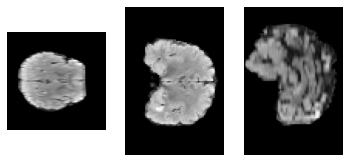

In [8]:
# Plot axial, coronal and sagittal slices of a training sample
check_data = first(train_loader)
idx = 0

img = check_data["image"][idx,0]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[...,img.shape[2]//2], cmap="gray")
ax = axs[1]
ax.imshow(img[:,img.shape[1]//2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0]//2, ...], cmap="gray")
#plt.savefig("training_examples.png")

## Download the validation set

In [9]:
val_ds = DecathlonDataset(root_dir=root_dir, task = 'Task01_BrainTumour', section="validation",
                            cache_rate=0.1, # you may need a few Gb of RAM... Set to 0 otherwise
                            num_workers=4,
                            download=False, # Set download to True if the dataset hasnt been downloaded yet
                            seed=0, transform = train_transforms) 
val_loader = DataLoader(val_ds, batch_size=2, shuffle=True, num_workers=4)
print(f'Image shape {val_ds[0]["image"].shape}')

Loading dataset: 100%|██████████| 9/9 [00:04<00:00,  1.87it/s]

Image shape torch.Size([1, 96, 96, 64])


## Define Networks

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda


In [11]:
autoencoder = AutoencoderKL(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    num_channels=32,
    latent_channels=3,
    ch_mult=(1, 2, 2),
    num_res_blocks=1,
    norm_num_groups=16,
    attention_levels=(False, False, True),
)
autoencoder.to(device)

unet = DiffusionModelUNet(
    spatial_dims=3,
    in_channels=3,
    out_channels=3,
    num_res_blocks=1,
    attention_resolutions=[4, 2],
    channel_mult=[1, 2, 2],
    model_channels=64,
    # TODO: play with this number
    num_heads=1,
)
unet.to(device)

scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="linear",
    beta_start=0.0015,
    beta_end=0.0195,
)

inferer = DiffusionInferer(scheduler)

discriminator = PatchDiscriminator(
    spatial_dims=3,
    num_layers_d=3,
    num_channels=32,
    in_channels=1,
    out_channels=1,
    kernel_size=4,
    activation="LEAKYRELU",
    norm="BATCH",
    bias=False,
    padding=1,
)
discriminator.to(device);

## Define Losses

In [12]:
l1_loss = L1Loss()
adv_loss = PatchAdversarialLoss(criterion="least_squares")
loss_perceptual = PerceptualLoss(spatial_dims = 3, network_type = 'squeeze', is_fake_3d = True, fake_3d_ratio= 0.2)
loss_perceptual.to(device)
def KL_loss(z_mu, z_sigma):
    kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim = [1, 2, 3, 4])
    return torch.sum(kl_loss) / kl_loss.shape[0]

adv_weight = 0.01
perceptual_weight = 0.001
kl_weight = 1e-6

In [13]:
optimizer_g = torch.optim.Adam(params=autoencoder.parameters(), lr=1e-4)
optimizer_d = torch.optim.Adam(params=discriminator.parameters(), lr=5e-4)

## Train AutoEncoder

In [14]:
# TODO: Add lr_scheduler with warm-up
# TODO: Add EMA model

n_epochs = 30
autoencoder_warm_up_n_epochs = 5
val_interval = 10
epoch_recon_loss_list = []
epoch_gen_loss_list = []
epoch_disc_loss_list = []
val_recon_epoch_loss_list = []
intermediary_images = []
n_example_images = 4

for epoch in range(n_epochs):
    autoencoder.train()
    discriminator.train()
    epoch_loss = 0
    gen_epoch_loss = 0
    disc_epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=110)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"][:,[channel],...].to(device) # choose only one of Brats channels
        optimizer_g.zero_grad(set_to_none=True)

        # Generator part
        reconstruction, z_mu, z_sigma  = autoencoder(images)
        kl_loss = KL_loss(z_mu, z_sigma)

        recons_loss = l1_loss(reconstruction.float(), images.float())
        p_loss = loss_perceptual(reconstruction.float(), images.float())
        loss_g = recons_loss + kl_weight * kl_loss + perceptual_weight * p_loss
        
        if epoch > autoencoder_warm_up_n_epochs:
            logits_fake = discriminator(reconstruction.contiguous().float())[-1]
            generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
            loss_g +=adv_weight * generator_loss

        loss_g.backward()
        optimizer_g.step()
        
        if epoch > autoencoder_warm_up_n_epochs:
            # Discriminator part
            logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
            loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
            logits_real = discriminator(images.contiguous().detach())[-1]
            loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
            discriminator_loss = (loss_d_fake + loss_d_real) * 0.5

            loss_d = adv_weight * discriminator_loss

            loss_d.backward()
            optimizer_d.step()

        epoch_loss += recons_loss.item()
        if epoch > autoencoder_warm_up_n_epochs:
            gen_epoch_loss += generator_loss.item()
            disc_epoch_loss += discriminator_loss.item()

        progress_bar.set_postfix(
            {
                "recons_loss": epoch_loss / (step + 1),
                "gen_loss": gen_epoch_loss / (step + 1),
                "disc_loss": disc_epoch_loss / (step + 1),
            }
        )
    epoch_recon_loss_list.append(epoch_loss / (step + 1))
    epoch_gen_loss_list.append(gen_epoch_loss / (step + 1))
    epoch_disc_loss_list.append(disc_epoch_loss / (step + 1))
    # TODO: validation step

Epoch 29: 100%|███████| 194/194 [01:25<00:00,  2.26it/s, recons_loss=0.0194, gen_loss=0.0968, disc_loss=0.297]


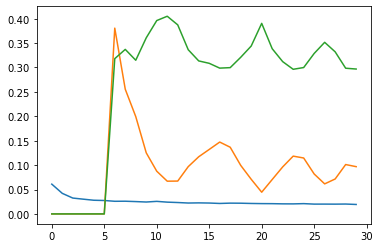

In [15]:
plt.plot(epoch_recon_loss_list) 
plt.plot(epoch_gen_loss_list) 
plt.plot(epoch_disc_loss_list);

### Visualise reconstructions

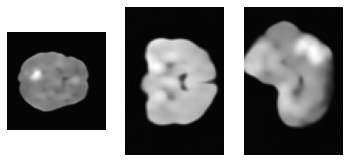

In [16]:
# Plot axial, coronal and sagittal slices of a training sample
idx = 0
img = reconstruction[idx, channel].detach().cpu().numpy() # images
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[...,img.shape[2]//2], cmap="gray")
ax = axs[1]
ax.imshow(img[:,img.shape[1]//2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0]//2, ...], cmap="gray")
plt.savefig("reconstruction_examples.png")
#plt.savefig("image_examples.png")

## Train Diffusion Model

In [17]:
optimizer_diff = torch.optim.Adam(params=unet.parameters(), lr=1e-4)

In [18]:
n_epochs = 30
val_interval = 50
epoch_loss_list = []
val_epoch_loss_list = []

autoencoder.eval()
scaler = GradScaler()

for epoch in range(n_epochs):
    unet.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"][:,[channel],...].to(device)
        optimizer_diff.zero_grad(set_to_none=True)
        z_mu, z_sigma = autoencoder.encode(images)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(z_mu).to(device)

            # Get model prediction
            noise_pred = inferer(inputs=z_mu, diffusion_model=unet, noise=noise)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer_diff)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix(
            {
                "loss": epoch_loss / (step + 1),
            }
        )
    epoch_loss_list.append(epoch_loss / (step + 1))

Epoch 29: 100%|████████| 194/194 [01:12<00:00,  2.67it/s, loss=0.0146]


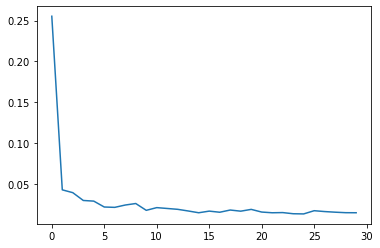

In [19]:
plt.plot(epoch_loss_list);

## Image generation

In [20]:
autoencoder.eval()
unet.eval()

noise = torch.randn((1, 3, 24, 24, 16))
noise = noise.to(device)
scheduler.set_timesteps(num_inference_steps=1000)
latent = inferer.sample(
    input_noise=noise, diffusion_model=unet, scheduler=scheduler
)
synthetic_images = autoencoder.decode(latent)

100%|██████████| 1000/1000 [00:41<00:00, 23.99it/s]


### Visualise Synthetic

In [1]:
idx = 0
img = synthetic_images[idx, channel].detach().cpu().numpy() # images
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[...,img.shape[2]//2], cmap="gray")
ax = axs[1]
ax.imshow(img[:,img.shape[1]//2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0]//2, ...], cmap="gray")
plt.savefig("synthetic_examples.png")

NameError: name 'synthetic_images' is not defined

## Clean-up data

In [22]:
if directory is None:
    shutil.rmtree(root_dir)